# We are going to look at making the GloVE based version of Node2Vec

This is the GloVE as node2vec is to word2vec.

Papers:

 - [GloVE](http://www.aclweb.org/anthology/D14-1162)
 - [node2vec](https://cs.stanford.edu/people/jure/pubs/node2vec-kdd16.pdf)

In [6]:
using Pkg
pkg"activate .."

In [2]:
using NBInclude
@nbinclude("utils.ipynb")

color_clusters (generic function with 2 methods)

# Loading Data

Les Mis, from Knuth

We will use:

 - the **JSON** package for loading the dat.
 - **LightGraphs** with its **SimpleWeightedGraph**  component for representing it as a graph
 - **MLDataUtils** to convert the node labels between text and node id


In [3]:
using JSON
using LightGraphs, SimpleWeightedGraphs
using MLDataUtils

In [4]:
const data = JSON.parse(open("jean.json"))

Dict{String,Any} with 2 entries:
  "nodes" => Any[Dict{String,Any}("id"=>"Myriel","group"=>1), Dict{String,Any}(…
  "links" => Any[Dict{String,Any}("source"=>"Napoleon","target"=>"Myriel","valu…

We'll define helper function to change between name and id

In [5]:
const characters = LabelEnc.NativeLabels([character["id"] for character in data["nodes"]])
char_id(name) = convertlabel(LabelEnc.Indices, name, characters)
char_name(ind) = MLDataUtils.ind2label(ind, characters) # hack around https://github.com/JuliaML/MLLabelUtils.jl/issues/18

const char_group = [character["group"] for character in data["nodes"]];

In [6]:
const les_graph = SimpleWeightedGraph(nlabel(characters))
for link in data["links"]
    add_edge!(les_graph,
        char_id(link["source"]),
        char_id(link["target"]),
        link["value"]
    )
end
les_graph

┌ Warning: Note: adding edges to this graph type is not performant.
└ @ SimpleWeightedGraphs /home/wheel/oxinabox/.julia/packages/SimpleWeightedGraphs/UuCCE/src/simpleweightedgraph.jl:96


{77, 254} undirected simple Int64 graph with Float64 weights

### External Truth Plot
using provided lavels

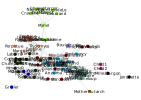

In [255]:
goodplot(les_graph,
    nodelabel=char_name.(vertices(les_graph)),
    nodefillc = color_clusters(char_group.+1),
    node_scaling=100,
    node_scale = 0.6
)

We can look at the weighted graph

In [4]:
collect(weights(les_graph))

77×77 Array{Float64,2}:
  0.0  1.0  8.0  10.0  1.0  1.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  1.0  0.0  0.0   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  8.0  0.0  0.0   6.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 10.0  0.0  6.0   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  1.0  0.0  0.0   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  1.0  0.0  0.0   0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  1.0  0.0  0.0   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  1.0  0.0  0.0   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  2.0  0.0  0.0   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  1.0  0.0  0.0   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
  0.0  0.0  0.0   0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
  5.0  0.0  3.0   3.0  0.0  0.0  0.0     1.0  1.0  1.0  0.0  0.0  0.0  0.0
  0.0  0.0  0.0   0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 

# Own Investigation 1


Just investigating the `C` embedding matrix for now,
though we have the `V` matrix as well.

In Glove they use the sum of the `C` and `V`.

In [5]:
@nbinclude("core.ipynb")

nodeGLoVE (generic function with 2 methods)

In [17]:

W = prob_norm(collect(weights(les_graph)))
@time X = cooccurance_matrix(W, 10)
C,V = nodeGLoVE(X, 16; time_limit=2*60*60)

  0.361181 seconds (849.72 k allocations: 34.456 MiB, 64.40% gc time)
Iter     Function value   Gradient norm 
     0     1.311146e+08     1.003421e+05
     1     7.329446e+07     3.607542e+05
     2     3.559643e+07     4.431158e+05
     3     1.919764e+07     3.927237e+05
     4     5.467488e+06     2.556351e+05
     5     4.177327e+05     5.552910e+04
     6     2.895834e+05     1.942539e+04
     7     2.769743e+05     8.105787e+03
     8     2.622985e+05     1.609972e+04
     9     1.248464e+05     3.613644e+04
    10     1.042465e+05     8.882239e+03
    11     1.006071e+05     2.045736e+03
    12     9.840533e+04     5.999661e+03
    13     7.393464e+04     1.129802e+04


([1.76545 -2.55792 … 2.21495 -0.160618; 1.83264 -2.14363 … 3.02 0.228675; … ; 1.49547 -2.09692 … 3.2353 -0.313939; 2.20341 -1.76126 … 2.94745 0.850977], [2.4556 2.3783 … 2.58012 2.67787; -3.99604 -3.38876 … -3.7289 -3.73933; … ; 1.01928 0.680751 … 0.997217 0.638104; -0.0679977 -0.0865482 … 0.347246 0.560765])

## NearestNeighbors

In [18]:
using NearestNeighbors, Distances

In [19]:
size(C)

(77, 16)

In [20]:
balltree = BallTree(collect(C'), Euclidean(); reorder = false)
function nearestneighbours(id, n=5, balltree=balltree)
    ids, dists = knn(balltree, C'[:,id], n, true)
    [char_name.(ids) dists]
end

function nearestneighbours(name::AbstractString, args...)
    nearestneighbours(char_id(name), args...)
end

nearestneighbours (generic function with 4 methods)

In [21]:
nearestneighbours("Valjean", 10)

10×2 Array{Any,2}:
 "Valjean"        0.0    
 "Gavroche"       1.08194
 "Mme.Pontmercy"  1.14184
 "Bahorel"        1.36965
 "Mlle.Vaubois"   1.37296
 "Anzelma"        1.38524
 "Thenardier"     1.39731
 "Child1"         1.42169
 "Enjolras"       1.42603
 "Prouvaire"      1.42764

In [22]:
nearestneighbours("Cosette", 25)

25×2 Array{Any,2}:
 "Cosette"          0.0    
 "Myriel"           0.79169
 "Count"            1.03892
 "Labarre"          1.05278
 "Montparnasse"     1.10581
 "Mme.deR"          1.18747
 "Gribier"          1.21065
 "Javert"           1.25379
 "Feuilly"          1.29047
 "Cochepaille"      1.296  
 "Courfeyrac"       1.29691
 "Mme.Thenardier"   1.33193
 "Babet"            1.34471
 "Brevet"           1.35635
 "Lt.Gillenormand"  1.36219
 "Fauchelevent"     1.38393
 "Mme.Magloire"     1.3858 
 "Claquesous"       1.4305 
 "Zephine"          1.43424
 "Simplice"         1.4596 
 "MotherInnocent"   1.4703 
 "Gueulemer"        1.48268
 "Dahlia"           1.53265
 "Fantine"          1.57991
 "Perpetue"         1.58712

## TSne

In [34]:
using TSne
using Plots
pyplot()

Plots.PyPlotBackend()

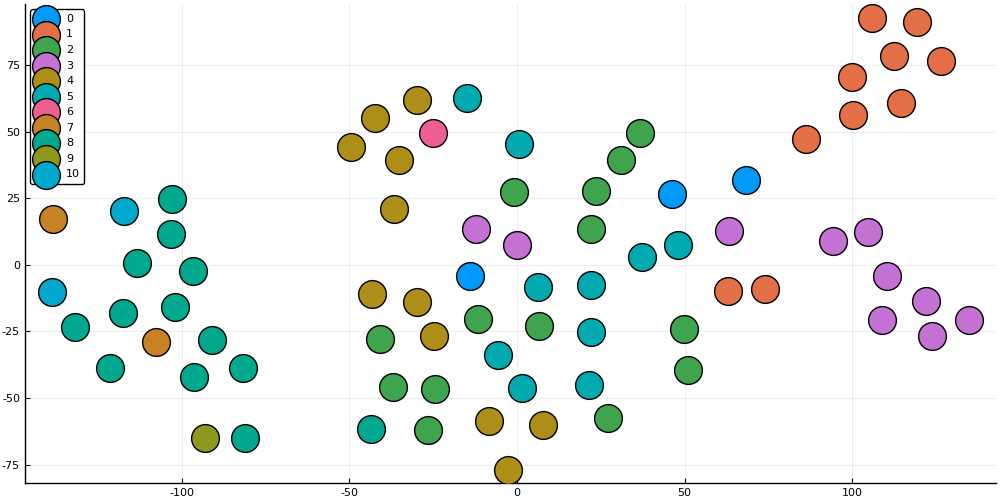

In [248]:
Y = tsne(C, 2, 50,1000, 20.0)
scatter(Y[:,1], Y[:,2],  group=char_group;
    markersize=20, size=(1000,500))

In [75]:
@nbinclude("utils.ipynb")

show_cluster (generic function with 2 methods)

## Clustering

In [93]:
using Clustering

show_cluster_lesmis(res) = show_cluster(res)  do id
    char_group[id], "\t", char_name(id)
end

show_cluster_lesmis (generic function with 1 method)

In [92]:
res = affinityprop(pairwise(CosineDist(), C'))
show_cluster_lesmis(res)

1	Myriel
1	Geborand
2	Valjean
2	Mme.deR
2	Gervais
3	Listolier
3	Fameuil
3	Favourite
3	Dahlia
3	Zephine
4	Thenardier
0	Fauchelevent
2	Bamatabois
3	Perpetue
2	Judge
2	Champmathieu
4	Anzelma
5	Woman2
7	Jondrette
7	Mme.Burgon
8	Gavroche
5	Gillenormand
5	Mlle.Gillenormand
5	Mme.Pontmercy
5	Lt.Gillenormand
5	BaronessT
8	Combeferre
8	Prouvaire
8	Bahorel
8	Bossuet
8	Grantaire
9	MotherPlutarch
4	Claquesous
4	Montparnasse
5	Toussaint
4	Brujon
-------------------------------
1	Napoleon
1	Mlle.Baptistine
1	Mme.Magloire
1	CountessdeLo
1	Champtercier
1	Count
1	OldMan
2	Labarre
3	Marguerite
2	Isabeau
3	Tholomyes
3	Blacheville
3	Fantine
4	Mme.Thenardier
5	Cosette
4	Javert
2	Simplice
2	Scaufflaire
2	Woman1
2	Brevet
2	Chenildieu
2	Cochepaille
4	Pontmercy
0	MotherInnocent
0	Gribier
8	Marius
10	Child2
-------------------------------
1	Cravatte
6	Boulatruelle
4	Eponine
5	Magnon
5	Mlle.Vaubois
8	Mabeuf
8	Enjolras
8	Feuilly
8	Courfeyrac
8	Joly
4	Gueulemer
4	Babet
10	Child1
8	Mme.Hucheloup
-------------------

In [84]:
assignments(res)

77-element Array{Int64,1}:
 1
 3
 3
 3
 3
 1
 3
 2
 3
 3
 3
 1
 3
 ⋮
 2
 1
 1
 2
 2
 1
 1
 1
 2
 3
 1
 2

In [38]:
res = kmeans(collect(C'), length(unique(char_group)))
show_cluster(res)

1	Myriel
1	Count
2	Labarre
2	Mme.deR
4	Mme.Thenardier
5	Cosette
2	Simplice
0	MotherInnocent
0	Gribier
4	Babet
-------------------------------
1	Napoleon
2	Isabeau
3	Zephine
0	Fauchelevent
2	Chenildieu
4	Eponine
5	Lt.Gillenormand
8	Mabeuf
8	Feuilly
-------------------------------
1	Mlle.Baptistine
1	Geborand
1	Champtercier
1	Cravatte
1	OldMan
3	Marguerite
3	Fantine
2	Bamatabois
2	Brevet
2	Cochepaille
8	Combeferre
8	Bossuet
4	Brujon
-------------------------------
1	Mme.Magloire
1	CountessdeLo
3	Perpetue
2	Woman1
5	Woman2
7	Mme.Burgon
8	Joly
-------------------------------
2	Valjean
2	Gervais
4	Pontmercy
6	Boulatruelle
4	Anzelma
8	Gavroche
5	Mme.Pontmercy
8	Prouvaire
8	Bahorel
8	Grantaire
5	Toussaint
10	Child1
10	Child2
-------------------------------
3	Tholomyes
3	Fameuil
3	Blacheville
3	Favourite
3	Dahlia
2	Champmathieu
5	Magnon
5	BaronessT
-------------------------------
3	Listolier
5	Gillenormand
-------------------------------
4	Thenardier
4	Javert
2	Scaufflaire
5	Mlle.Gillenormand


## Homophily
We wish to find communities

Figure 3, top in Node2Vec paper

 - 16 dims
 - p=1, q=0.5
 - 6 Clusters

In [232]:
W = prob_norm(collect(weights(les_graph)))
@time X = cooccurance_matrix(W, 10, 1.0, 0.5) |> collect
Ch,Vh = nodeGLoVE(X, 16; time_limit=2*60*60)

  0.144310 seconds (2.04 M allocations: 52.727 MiB, 14.41% gc time)
Iter     Function value   Gradient norm 
     0     2.190586e+08     1.002204e+05
     1     1.977976e+08     3.033914e+05
     2     4.539090e+07     1.132372e+06
     3     3.517134e+07     1.377945e+06
     4     7.045485e+06     4.732424e+05
     5     1.377019e+06     1.861069e+05
     6     6.584492e+05     5.069507e+04
     7     5.974025e+05     2.134113e+04
     8     4.999029e+05     6.566330e+04
     9     2.432565e+05     4.229673e+04
    10     1.646356e+05     9.585590e+03
    11     1.565911e+05     8.397236e+03
    12     1.536392e+05     4.864224e+03
    13     1.385118e+05     2.247787e+04
    14     1.126124e+05     2.658802e+04
    15     1.019971e+05     4.096374e+03
    16     1.012793e+05     3.827730e+03
    17     8.603308e+04     2.737821e+04
    18     7.739203e+04     6.690290e+03
    19     7.427780e+04     3.043365e+03
    20     7.318126e+04     5.139192e+03
    21     7.033086e+04     1.

([1.22084 3.19281 … 0.253854 0.844554; 1.53345 3.4663 … 0.164637 -0.126226; … ; 1.27801 4.29274 … 0.399444 1.40723; 0.748672 4.59079 … 0.927793 1.36036], [-2.51454 -2.2506 … -2.72732 -2.44202; 0.00588649 -0.154004 … 0.139098 0.280407; … ; -2.9784 -2.7579 … -3.00677 -2.29428; 0.459496 0.202147 … 1.16147 1.37921])

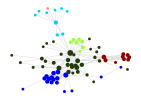

In [241]:
clustering_res = kmeans(collect(Ch'+Vh), 6)
#show_cluster_lesmis(clustering_res)
goodplot(les_graph,
   # nodelabel=char_name.(vertices(les_graph)),
    nodefillc = color_clusters(clustering_res)
)

## Structural Equivilence
We wish to find nodes that occupy similar rols

Figure 3, bottom in Node2Vec paper

 - 16 dims
 - p=1, q=2
 - 3 Clusters

In [186]:
W = prob_norm(collect(weights(les_graph)))
@time X = cooccurance_matrix(W, 10, 1.0, 2.0) |> collect
Cs,Vs = nodeGLoVE(X, 16; time_limit=2*60*60)

  0.156136 seconds (2.04 M allocations: 52.727 MiB, 17.67% gc time)
Iter     Function value   Gradient norm 
     0     7.661194e+07     8.537505e+04
     1     6.544701e+07     9.001076e+04
     2     3.684320e+06     2.055960e+05
     3     2.293787e+06     1.596885e+05
     4     8.639806e+05     5.556851e+04
     5     3.605309e+05     1.583184e+04
     6     3.338804e+05     7.130828e+03
     7     2.503493e+05     2.729267e+04
     8     1.060805e+05     1.032958e+04
     9     8.943785e+04     4.752841e+03
    10     8.440933e+04     3.030865e+03
    11     8.134399e+04     2.553229e+03
    12     7.576085e+04     7.389884e+03
    13     5.611040e+04     5.626743e+03
    14     5.272543e+04     3.030981e+03
    15     5.039409e+04     1.849986e+03
    16     4.569459e+04     3.009005e+03
    17     3.989684e+04     5.225734e+03
    18     2.734314e+04     5.324933e+03
    19     2.329008e+04     2.604487e+03
    20     2.228434e+04     7.602303e+02
    21     2.166571e+04     1.

([0.124556 1.07841 … 0.471947 0.244321; 0.208461 0.880744 … 0.70929 -0.202314; … ; 0.498158 1.7914 … 0.626648 0.650543; 0.692159 0.622342 … 0.574903 0.413071], [-1.03739 -0.48278 … -1.04687 -0.785223; 0.65887 0.222438 … 0.875197 0.0888309; … ; -2.23745 -1.32788 … -1.53618 -1.81412; 0.0975374 -0.212523 … 0.158789 -0.239582])

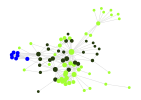

In [245]:
clustering_res = kmeans(collect(Cs'), 3)
#show_cluster_lesmis(clustering_res)
goodplot(les_graph,
   # nodelabel=char_name.(vertices(les_graph)),
    nodefillc = color_clusters(clustering_res),  
)